## Compare PGS scores
Compare output from the different PGS prediction models.

In [95]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [96]:
# plink
Output_dir = 'PGS_plink'
Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = 'best_fit_prs.csv'

best_fit = pd.read_csv(os.path.join(Output_dir, best_fit_file))

# scores
scores = pd.read_csv(os.path.join(Output_dir, f"{Data_prefix}.{best_fit['Threshold'].values[0]}.profile"), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs HEIGHT
plt.plot(scores['SCORE'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{Plink}$')
plt.ylabel('height')

Text(0, 0.5, 'height')

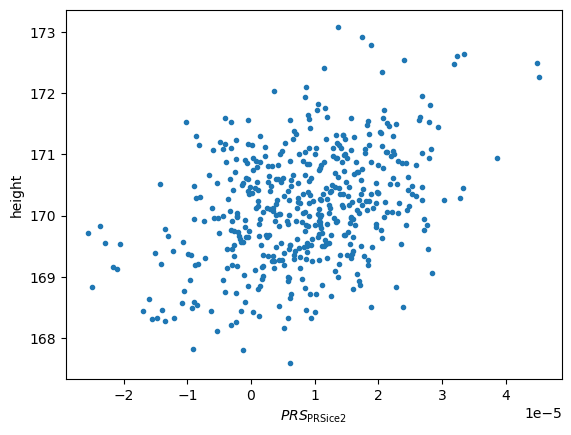

In [ ]:
# PRSice-2
# plink
Output_dir = 'PGS_prsice2'
Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = f'{Data_prefix}.best'

# scores
scores = pd.read_csv(os.path.join(Output_dir, best_fit_file), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs HEIGHT
plt.plot(scores['PRS'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{PRSice2}$')
plt.ylabel('height')